In [1]:
import sys
import glob
import os
import ee
import math
import pandas as pd
import numpy as np
import geopandas as gp

import matplotlib.pyplot as plt
import rsfuncs as rs

from scipy import stats
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

from pandas.tseries.offsets import MonthEnd, SemiMonthEnd
from datetime import datetime, timedelta
from datetime import datetime as dt

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers, optimizers

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [10,6]
ee.Initialize()

Using TensorFlow backend.
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/a

In [2]:
# Numeric NLCD vals to class labels
nlcd= {0: "Open water",
1 : "Perennial ice/snow",
2 : "Developed",
3 : "Developed, low intensity",
4 : "Developed, medium intensity",
5 : "Developed high intensity",
6 : "Barren land (rock/sand/clay)",
7 : "Deciduous forest", 
8 : "Evergreen forest",
9 : "Mixed forest",
10 : "Dwarf scrub",
11 : "Shrub/scrub",
12 : "Grassland/herbaceous",
13 : "Sedge/herbaceous",
14 : "Lichens",
15 : "Moss",
16 : "Pasture/hay",
17 : "Cultivated crops",
18 : "Woody wetlands",
19 : "Emergent herbaceous wetlands"}


In [3]:
# Read data

In [4]:
states_file = gp.read_file("../shape/states.shp")
states = states_file[~states_file['STATE_ABBR'].isin(["AK", "HI", "PR", "VI"])]

site_file = gp.read_file("../shape/scan_sites.shp")
sites = site_file[~site_file['state'].isin(["AK", "HI", "PR", "VI"])]

In [5]:
# Read and formate data 
df = pd.read_csv("../data/all_dat_f.csv")
df.rename(columns={ df.columns[0]: "site" , df.columns[1]:"date"}, inplace = True)
df.replace([np.inf, -np.inf], np.nan, inplace = True)
df = df.set_index(pd.to_datetime(df.date))
df['date'] = pd.to_datetime(df.date)
# Remove outliers
# df = df[~(np.abs(df.psi_rz-df.psi_rz.mean()) > (df.psi_rz.std()))]

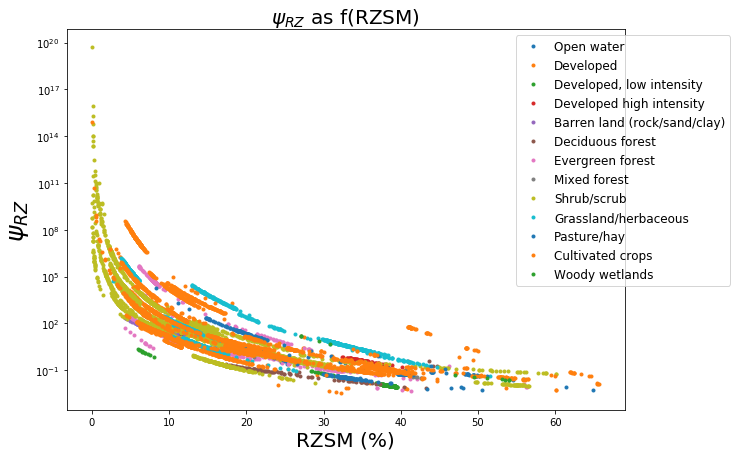

In [6]:
# Plot psi as f(SM) by lc type

groups = df.groupby('lc_type')

fig, ax = plt.subplots(figsize=(10,7))

for name, group in groups:
    ax.plot(group.rzsm, group.psi_rz, marker='o', linestyle='', ms=3, label=nlcd[name])
    
ax.legend(bbox_to_anchor=(1.2, 1),prop={'size': 12})
ax.set_title("$\psi_{RZ}$ as f(RZSM)", size = 20)
ax.set_ylabel("$\psi_{RZ}$", size = 25)
ax.set_yscale("log")
ax.set_xlabel("RZSM (%)", size = 20)

plt.show()

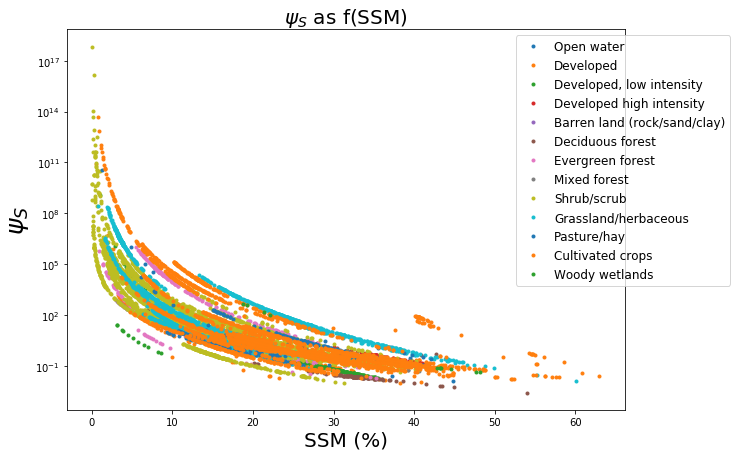

In [7]:
# Plot psi as f(SSM) by lc type

groups = df.groupby('lc_type')

fig, ax = plt.subplots(figsize=(10,7))

for name, group in groups:
    ax.plot(group.ssm, group.psi_s, marker='o', linestyle='', ms=3, label=nlcd[name])
    
ax.legend(bbox_to_anchor=(1.2, 1),prop={'size': 12})
ax.set_title("$\psi_{S}$ as f(SSM)", size = 20)
ax.set_ylabel("$\psi_{S}$", size = 25)
ax.set_yscale("log")
ax.set_xlabel("SSM (%)", size = 20)

plt.show()

In [8]:
# Filter the data. 

# Drop days with 2day precip less than 1 mm
df = df[df.precip<1]

# Remove Urban Areas
df = df[df.lc_type != 2]
df = df[df.lc_type != 3]

# Remove sites with <10 datapoints
for i in df.site.unique():
    if len(df[df.site == i]) < 10:
        df = df[df.site != i]

In [9]:
site_lens = {}
lc_col = {}
for i in df.site.unique():
    sdf = df[df.site==i]
    site_lens[i] = (len(sdf))
    try:
        lc_col[i]= nlcd[sdf.lc_type[0]]
    except:
        continue

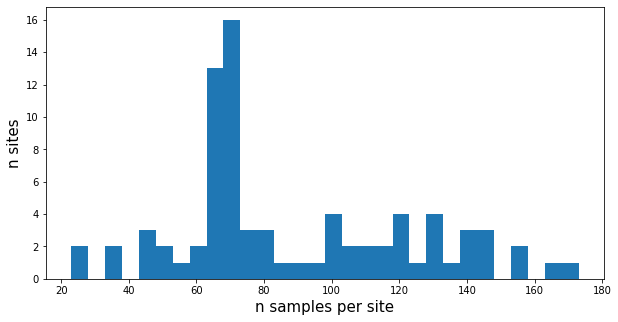

In [10]:
plt.figure(figsize = (10,5))
plt.hist(np.array(list(site_lens.values())), bins = 30)[-1]
plt.xlabel("n samples per site", size = 15)
plt.ylabel("n sites", size = 15)
plt.show()

In [11]:
t = pd.DataFrame.from_dict(list(site_lens.items()))
t.columns = ['site_id', 'len']

t2 = pd.DataFrame.from_dict(list(lc_col.items()))
t2.columns = ['site_id', 'type']

t = pd.merge(t,t2, on = "site_id")
# t.set_index('site_id', inplace = True);

In [12]:
gdf = pd.merge(sites,t,how = "inner", left_index = True, right_index = True)

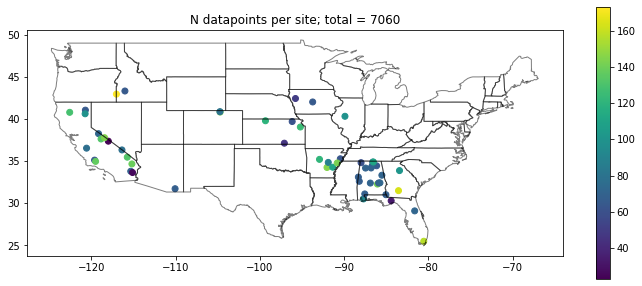

In [13]:
fig, ax = plt.subplots(figsize = (12,5))

ax.set_title("N datapoints per site; total = {}".format(sum(site_lens.values())))
gdf.plot(ax = ax, column = "len", legend = True)
states.plot(ax = ax, color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)
plt.show()

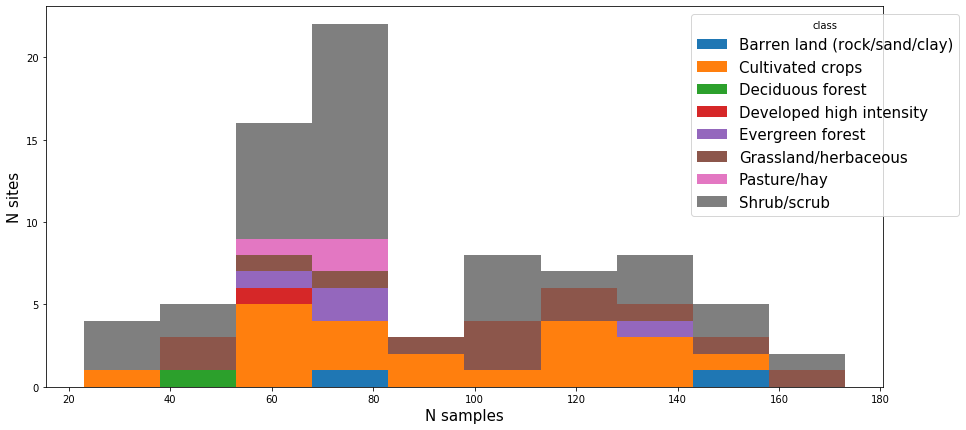

In [14]:
# Stacked histogram colored by landcover type
plt.figure(figsize=(15,7))

_, edges = np.histogram(t["len"], bins=10)
histdata = []; labels=[]
for n, group in t.groupby("type"):
    histdata.append(np.histogram(group["len"], bins=edges)[0])
    labels.append(n)

hist = np.array(histdata) 
histcum = np.cumsum(hist,axis=0)

plt.bar(edges[:-1],hist[0,:], width=np.diff(edges)[0],
            label=labels[0], align="edge")

for i in range(1,len(hist)):
    plt.bar(edges[:-1],hist[i,:], width=np.diff(edges)[0],
            bottom=histcum[i-1,:],label=labels[i], align="edge")

plt.legend(title="class", bbox_to_anchor=(1.1, 1), prop={'size': 15})
plt.ylabel("N sites", size = 15)
plt.xlabel("N samples", size = 15)
plt.show()

In [15]:
D = {}
for k,v in nlcd.items():
    t = df[df.lc_type == k]
    if len(t) == 0:
        continue
    else:
        D[v] = len(t)

Text(85.875, 0.5, 'n samples')

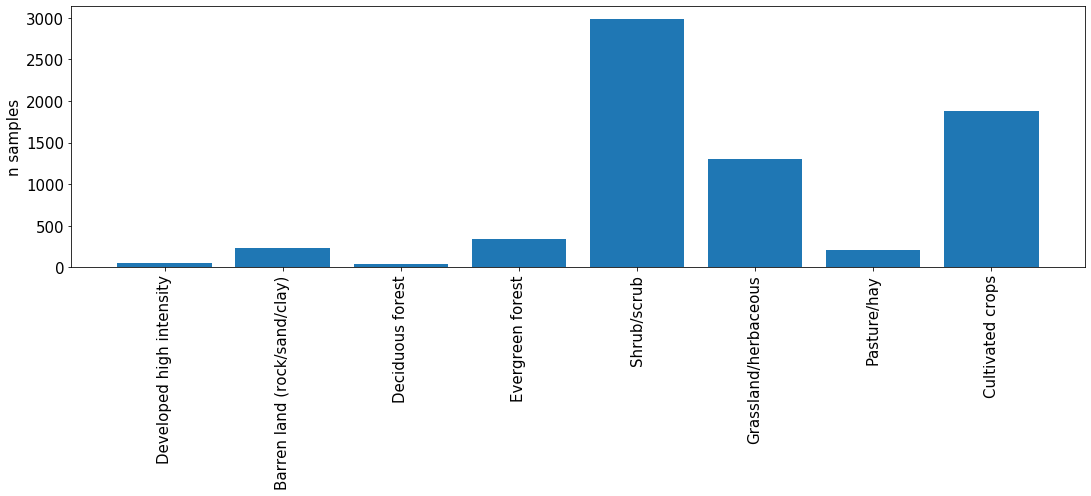

In [16]:
plt.figure(figsize = (15,7))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()), rotation='vertical', size = 15)
plt.yticks(size = 15)
plt.tight_layout()
plt.ylabel("n samples", size = 15)

In [17]:
# Calculate spectral indices

df['ndvi'] = (df.B5 - df.B4) / (df.B5 + df.B4)
df["ndmi"] = (df.B5 - df.B6) / (df.B5 + df.B6)
df["evi"] = 2.5*(df.B5 - df.B4) / (df.B5 + 6*df.B4- 7.5*df.B2 + 1)


In [18]:
# For the backscatter columns (df.vv, df.hv), delete any zeros, nans, deal with weird formatting, and calc the mean 

vv_eff = []

for i in df.vv:
    line = i.replace("[","")
    line = line.replace("]","")
    line = ' '.join(line.split())
    data = [float(i) for i in line.split(' ')]
    data = [i for i in data if i !=0.]
    vv_eff.append(np.nanmean(data))
    

hv_eff = []

for i in df.hv:
    if type(i) is float:
        hv_eff.append(np.nan)
    else:
        line = i.replace("[","")
        line = line.replace("]","")
        line = ' '.join(line.split())
        data = [float(i) for i in line.split(' ')]
        data = [i for i in data if i !=0.]
        hv_eff.append(np.nanmean(data))

/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


In [19]:
df['vv'] = vv_eff
df['hv'] = hv_eff

In [22]:
# calc the 12 day means for each site: 
df = df.groupby(['site']).resample('12D').mean().fillna(np.nan).dropna()


In [23]:
def compute_lags(df, n=3):
    df['vv_t1'] = df['vv'].shift(1)
    df['hv_t1'] = df['hv'].shift(1)
    df['vv_t2'] = df['vv'].shift(2)
    df['hv_t2'] = df['hv'].shift(2)
    df['vv_t3'] = df['vv'].shift(3)
    df['hv_t3'] = df['hv'].shift(3)

    return df

In [26]:
# fdf = df.groupby(['site']).resample('12D').mean().fillna(np.nan)

In [32]:
df = compute_lags(df)
# f = t.dropna()

In [31]:
# Filter out nonconsecutive dates
filtered = []

for i in t.site.unique():
    sdf = t[t.site==i]


    for i in sdf.index:   
        end = i[1]
        begin = end - pd.Timedelta(days=24)
        t = sdf[sdf.index.between(begin, end)]
        num_points = len(t)
        if num_points>6:
            filtered.append(t)

AttributeError: 'MultiIndex' object has no attribute 'between'

In [182]:
# df = None
# df = t.dropna()

In [183]:
# One hot encode the landcover types 
# one_hot = pd.get_dummies(df.lc_type, drop_first=True )
# X = pd.concat([X, one_hot], axis = 1)

In [104]:
# Select dependent variable, drop fluff from input (independent) feats
df = df.dropna()

y = df.rzsm # Psi_RZ? 
X = df.drop(["site","rzsm", "ssm", "psi_rz","precip", "psi_s", "lc_type"], axis=1)

In [105]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(np.array(y).reshape(-1, 1))

In [107]:
# Train test split for validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Scale inputs
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [108]:
X_train.shape

(2502, 25)

In [109]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [110]:
# Modeling options
EPOCHS = int(20e3)
BATCHSIZE = int(2e5)
DROPOUT = 0.25
LOSS = 'mse'

Areg = regularizers.l2(1e-5)
Breg = regularizers.l2(1e-3)
Kreg = regularizers.l2(1e-15)
Rreg = regularizers.l2(1e-15)

In [97]:
def build_model(input_shape=(X_train.shape[0], X_train.shape[1])):
    
    model = Sequential()
    
    model.add(LSTM(10, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=DROPOUT,\
                  return_sequences=True, \
                  bias_regularizer= Breg))
    
    model.add(LSTM(10, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=DROPOUT,\
                    return_sequences=True, \
                    bias_regularizer= Breg))
    
    model.add(LSTM(10, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=DROPOUT,\
                   bias_regularizer= Breg))

    model.add(Dense(1))
    
    model.compile(loss=LOSS, optimizer='adam')
    # fit network
    
    return model

In [98]:
# model = build_model()

In [129]:
# create and fit the LSTM network

input_shape=(X_train.shape[1], X_train.shape[2])

model = Sequential()


model.add(LSTM(200, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=0.25,\
              return_sequences=True, \
              bias_regularizer= Breg))

model.add(LSTM(100, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=0.25,\
              return_sequences=True, \
              bias_regularizer= Breg))
model.add(LSTM(50, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=0.25,\
                return_sequences=True, \
                bias_regularizer= Breg))
model.add(LSTM(10, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=0.25,\
               bias_regularizer= Breg))

model.add(Dense(1))
model.compile(loss="mse", optimizer='adam')

In [130]:
model.fit(X_train, y_train, epochs=20000, batch_size=5000, verbose=2)

Epoch 1/20000
 - 3s - loss: 0.4680
Epoch 2/20000
 - 0s - loss: 0.4656
Epoch 3/20000
 - 0s - loss: 0.4632
Epoch 4/20000
 - 0s - loss: 0.4608
Epoch 5/20000
 - 0s - loss: 0.4583
Epoch 6/20000
 - 0s - loss: 0.4558
Epoch 7/20000
 - 0s - loss: 0.4532
Epoch 8/20000
 - 0s - loss: 0.4505
Epoch 9/20000
 - 0s - loss: 0.4477
Epoch 10/20000
 - 0s - loss: 0.4449
Epoch 11/20000
 - 0s - loss: 0.4418
Epoch 12/20000
 - 0s - loss: 0.4387
Epoch 13/20000
 - 0s - loss: 0.4354
Epoch 14/20000
 - 0s - loss: 0.4320
Epoch 15/20000
 - 0s - loss: 0.4284
Epoch 16/20000
 - 0s - loss: 0.4245
Epoch 17/20000
 - 0s - loss: 0.4205
Epoch 18/20000
 - 0s - loss: 0.4166
Epoch 19/20000
 - 0s - loss: 0.4124
Epoch 20/20000
 - 0s - loss: 0.4082
Epoch 21/20000
 - 0s - loss: 0.4041
Epoch 22/20000
 - 0s - loss: 0.4002
Epoch 23/20000
 - 0s - loss: 0.3963
Epoch 24/20000
 - 0s - loss: 0.3926
Epoch 25/20000
 - 0s - loss: 0.3898
Epoch 26/20000
 - 0s - loss: 0.3881
Epoch 27/20000
 - 0s - loss: 0.3861
Epoch 28/20000
 - 0s - loss: 0.3856
E

In [131]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test)

In [132]:
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 19.26 RMSE
Test Score: 17.70 RMSE


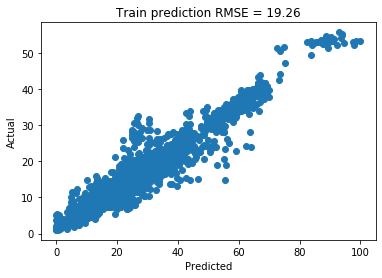

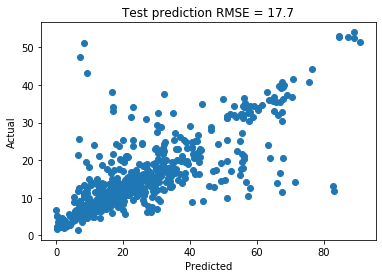

In [133]:
plt.title("Train prediction RMSE = {}".format(round(trainScore,2)))
plt.scatter(y_train*100, trainPredict)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.title("Test prediction RMSE = {}".format(round(testScore,2)))
plt.scatter(y_test*100, testPredict)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()